**This is a NLP problem where the task is to classify Fake News in an article. This notebook consists of various stages needed for identifying fake news such as data preprocessing, model experimentation, and evaluation of results.**

In [1]:
# Importing Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import nltk
import re
from nltk.corpus import stopwords
# nltk.download('stopwords')
from tensorflow.keras.layers import Embedding,Dropout
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.layers import LSTM,Bidirectional,GRU
from tensorflow.keras.layers import Dense

In [2]:
# Reading data from csv
train = pd.read_csv("fake-news-1/train.csv")
test  = pd.read_csv("fake-news-1/test.csv")
train.head()

,index,title,text,subject,date,class,Unnamed: 6
0,0,PRESIDENT TRUMP Explains New “America First” R...,That s what we re talking about! Another campa...,politics,"Aug 2, 2017",Fake,NaN
1,1,TERMINALLY ILL FORMER MISS WI: “Until my last ...,How is it that Sean Hannity is the only media ...,politics,"Oct 4, 2016",Fake,NaN
2,2,Cruz Humiliated By Moderator After Lie About ...,Almost immediately after learning that longtim...,News,"February 13, 2016",Fake,NaN
3,3,"Russia revels in Trump victory, looks to sanct...",MOSCOW (Reuters) - For all their mutual praise...,politicsNews,"November 9, 2016",Real,NaN
4,4,Trump's bid to open U.S. monuments to developm...,WASHINGTON (Reuters) - The Trump administratio...,politicsNews,"May 26, 2017",Real,NaN


In [3]:
test.head()

,index,title,text,subject,date
0,0,STUNNING TESTIMONY On The Devastation Illegal ...,Fantastic testimony on the disastrous results...,Government News,"Mar 21, 2016"
1,1,Pena Nieto told Trump Mexico won't pay for wal...,MEXICO CITY (Reuters) - Mexican President Enri...,politicsNews,"August 31, 2016"
2,2,"Actor George Clooney: I Support Hillary, And ...",Hillary Clinton has picked up a huge endorseme...,News,"March 4, 2016"
3,3,AWESOME LETTER TO OBAMA: Who is unfit to be pr...,Did anyone else think it was the ultimate iron...,left-news,"Aug 5, 2016"
4,4,This Ridiculously Creepy Vine May Prove Ted C...,There have been a lot of strange this that hav...,News,"February 8, 2016"


In [4]:
# Displaying rows and columns in dataset
print("There are {} number of rows and {} number of columns for training.".format(train.shape[0],train.shape[1]))
print("There are {} number of rows and {} number of columns for testing.".format(test.shape[0],test.shape[1]))

There are 40000 number of rows and 7 number of columns for training.
There are 4000 number of rows and 5 number of columns for testing.


**Checking Null Values**

In [5]:
# Checking the null values in training data.
train.isnull().sum()

index             0
title             0
text              0
subject           0
date              0
class             0
Unnamed: 6    39999
dtype: int64

In [6]:
# Checking the null values in testing data.
test.isnull().sum()

index      0
title      0
text       0
subject    0
date       0
dtype: int64

In [7]:
# Handling nan values in dataset using empty spaces
def handle_nan(train_data,test_data):
    '''Input: Data to the function containing Nan values.
       Output : Cleaned data containing no Nan values.
       Function: Cleaning Nan values.
     '''
    train = train_data.fillna(" ")
    test  = test_data.fillna(" ")
    return train,test

train,test = handle_nan(train,test)


In [8]:
# Dropping useless columns
train.drop(['index', 'subject', 'date', 'Unnamed: 6'], axis = 1, inplace = True)
test.drop(['index', 'subject', 'date'], axis = 1, inplace = True)

In [9]:
train.rename(columns={'class':'label'}, inplace = True)

In [10]:
train.head()

,title,text,label
0,PRESIDENT TRUMP Explains New “America First” R...,That s what we re talking about! Another campa...,Fake
1,TERMINALLY ILL FORMER MISS WI: “Until my last ...,How is it that Sean Hannity is the only media ...,Fake
2,Cruz Humiliated By Moderator After Lie About ...,Almost immediately after learning that longtim...,Fake
3,"Russia revels in Trump victory, looks to sanct...",MOSCOW (Reuters) - For all their mutual praise...,Real
4,Trump's bid to open U.S. monuments to developm...,WASHINGTON (Reuters) - The Trump administratio...,Real


In [11]:
test.head()

,title,text
0,STUNNING TESTIMONY On The Devastation Illegal ...,Fantastic testimony on the disastrous results...
1,Pena Nieto told Trump Mexico won't pay for wal...,MEXICO CITY (Reuters) - Mexican President Enri...
2,"Actor George Clooney: I Support Hillary, And ...",Hillary Clinton has picked up a huge endorseme...
3,AWESOME LETTER TO OBAMA: Who is unfit to be pr...,Did anyone else think it was the ultimate iron...
4,This Ridiculously Creepy Vine May Prove Ted C...,There have been a lot of strange this that hav...


In [12]:
train['label'] = train['label'].replace(['Fake'], 1)
train['label'] = train['label'].replace(['Real'], 0)

In [13]:
train.head()

,title,text,label
0,PRESIDENT TRUMP Explains New “America First” R...,That s what we re talking about! Another campa...,1
1,TERMINALLY ILL FORMER MISS WI: “Until my last ...,How is it that Sean Hannity is the only media ...,1
2,Cruz Humiliated By Moderator After Lie About ...,Almost immediately after learning that longtim...,1
3,"Russia revels in Trump victory, looks to sanct...",MOSCOW (Reuters) - For all their mutual praise...,0
4,Trump's bid to open U.S. monuments to developm...,WASHINGTON (Reuters) - The Trump administratio...,0


In [14]:
train['label'].value_counts()

1                   20886
0                   19113
February 5, 2017        1
Name: label, dtype: int64

In [15]:
i = train[((train.label == 'February 5, 2017'))].index
train = train.drop(i)

In [16]:
train['label'] = train['label'].astype(int)

In [17]:
train['label'].value_counts()

1    20886
0    19113
Name: label, dtype: int64

In [18]:
# Seperating Independent and dependent features
X = train.drop(columns=['label'],axis=1)
y = train['label']

In [19]:
# Creating One-Hot Representations
messages = X.copy()
messages.reset_index(inplace=True)
messages_test = test.copy()
messages_test.reset_index(inplace=True)

In [20]:
messages["text"][0]

'That s what we re talking about! Another campaign promise kept. No wonder the Democrats and their media allies fear President Trump. When is the last time a politician actually followed through on a promise they made to the American voters that helped them to get elected?President Trump joined two Republican senators on Wednesday to champion legislation overhauling legal immigration in America, calling for a merit-based system that would significantly cut admissions over the next decade.Speaking at the White House, the president called it  the most significant reform to our immigration system in a half century. As a candidate, I campaigned on creating a merit-based immigration system that protects U.S. workers and taxpayers, and that is why we are here today,  Trump said.He was joined by Georgia Sen. David Perdue and Arkansas Sen. Tom Cotton, the Republicans who first introduced the Reforming American Immigration for a Strong Economy, or the RAISE Act, in February. They have said the 

In [21]:
messages.head()

,index,title,text
0,0,PRESIDENT TRUMP Explains New “America First” R...,That s what we re talking about! Another campa...
1,1,TERMINALLY ILL FORMER MISS WI: “Until my last ...,How is it that Sean Hannity is the only media ...
2,2,Cruz Humiliated By Moderator After Lie About ...,Almost immediately after learning that longtim...
3,3,"Russia revels in Trump victory, looks to sanct...",MOSCOW (Reuters) - For all their mutual praise...
4,4,Trump's bid to open U.S. monuments to developm...,WASHINGTON (Reuters) - The Trump administratio...


In [22]:
messages_test.head()

,index,title,text
0,0,STUNNING TESTIMONY On The Devastation Illegal ...,Fantastic testimony on the disastrous results...
1,1,Pena Nieto told Trump Mexico won't pay for wal...,MEXICO CITY (Reuters) - Mexican President Enri...
2,2,"Actor George Clooney: I Support Hillary, And ...",Hillary Clinton has picked up a huge endorseme...
3,3,AWESOME LETTER TO OBAMA: Who is unfit to be pr...,Did anyone else think it was the ultimate iron...
4,4,This Ridiculously Creepy Vine May Prove Ted C...,There have been a lot of strange this that hav...


# Data Pre-processing
**In Data Pre-processing following steps are followed:** 
**1. Firstly, all the sequences except english characters are removed from the string.**
**2. Next, to avoid false predictions or ambiguity with upper and lowercase, all the characters in strings are converted    to lowercase.**
**3. Next, all the sentences are tokenized into words.**
**4. To facilitate fast processing, stemming is applied to the tokenized words.**
**5. Next, words are joined together and stored in the corpus.**

**Note: In this tutorial, we have used "merged" column for classification task. Also, the loop inside the function runs over all the examples in the merged column.**

In [23]:
# Performing data preprocessing on column 'title'
from nltk.stem.porter import PorterStemmer
ps = PorterStemmer()
def perform_preprocess(data):
    '''Input: Data to be processed
       Output: Preprocessed data
    '''
    corpus = []
    for i in range(0,len(data)):
        review = re.sub('[^a-zA-Z]',' ',data['title'][i])
        review = review.lower()
        review = review.split()
        review = [ps.stem(word) for word in review if word not in stopwords.words('english')]
        review = ' '.join(review)
        corpus.append(review)
    return corpus
    
train_corpus = perform_preprocess(messages)
test_corpus  = perform_preprocess(messages_test)
train_corpus[1]

'termin ill former miss wi last breath use voic tell mr trump realli video'

In [24]:
test_corpus[1]

'pena nieto told trump mexico pay wall presidenti spokesman'

**Below code converts the pre-processed words to one-hot vectors in the range of vocabulary size=5000. This is done to obtain numerical feature matrix**

In [25]:
# Converting to one-hot repr.
vocab_size = 5000
one_hot_train = [one_hot(word,vocab_size) for word in train_corpus]
one_hot_test  = [one_hot(word,vocab_size) for word in test_corpus]

In [26]:
one_hot_test[1]

[2239, 1330, 1360, 56, 3917, 75, 4140, 4882, 3190]

**Below code creates an embedding layer which applies "pre" padding to the one-hot encoded features with sentence length = 20. Padding is applied so that the length of every sequence in the dataset should be same.**

In [27]:
# Embedding Representation 
sent_length = 20
embedd_docs_train = pad_sequences(one_hot_train,padding='pre',maxlen=sent_length)
embedd_docs_test  = pad_sequences(one_hot_test,padding='pre',maxlen=sent_length)
print(embedd_docs_train)

[[2623 1080 4338 ... 1183 1818  245]
 [   0    0    0 ...   56 1266  245]
 [   0    0    0 ... 1478  951 4083]
 ...
 [   0 3897 3638 ...   32  507  245]
 [   0    0    0 ... 3261 4232 4464]
 [   0    0    0 ... 3787 1836  741]]


In [28]:
embedd_docs_train[0]

array([2623, 1080, 4338, 1767, 1387,  299, 2623, 2247, 3942, 1751, 2847,
       4262, 2247,  948, 1409, 4142, 2578, 1183, 1818,  245])

In [29]:
print(embedd_docs_test)

[[   0    0    0 ... 3593 1080  245]
 [   0    0    0 ... 4140 4882 3190]
 [   0    0    0 ... 1701   56 1261]
 ...
 [   0    0    0 ... 2279  480 2080]
 [   0    0    0 ... 2710  837   32]
 [   0    0    0 ... 1952 1409 2798]]


In [30]:
# Converting Embedding repr. to array
x_final = np.array(embedd_docs_train)
y_final = np.array(y)
x_test_final = np.array(embedd_docs_test)

In [31]:
# Dimensions of prev. array repr.
x_final.shape,y_final.shape,x_test_final.shape

((39999, 20), (39999,), (4000, 20))

**Dividing the dataset into training,validation and testing data (ratio: 80/10/10) using train_test_split technique.**

In [32]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x_final, y_final, test_size=0.1, random_state=42, stratify = y_final)
X_train, x_valid, Y_train, y_valid = train_test_split(x_train, y_train, test_size=0.1, random_state=42, stratify = y_train)
x_test_final = x_test_final

# Creating Models
**In this phase, several models are created and evaluated against various metrics shown using classification report.**

## Baseline Models

In [33]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import plot_roc_curve

In [34]:
# Put models in a dictionary
models = {"Logistic Regression": LogisticRegression(),
          "KNN": KNeighborsClassifier(),
          "Random Forest": RandomForestClassifier(),
          "Naive Bayes": MultinomialNB(),
          "Decision Tree Classifier": DecisionTreeClassifier(),
          "XGBoost Classifier": XGBClassifier(),
          "CatBoost Classifier": CatBoostClassifier(iterations=150)}

# Create a function to fit and score models
def fit_and_score(models, X_train, x_test, Y_train, y_test):
    """
    Fits and evaluates given machine learning models.
    models: a dict of different Scikit-Learn Machine Learning models
    X_train: Training data (no labels)
    X_test: Testing data (no labels)
    y_train: Training labels
    y_test: Test labels
    """
    
    # Set random seed
    np.random.seed(12)
    
    # Make a dictionary to keep model scores
    model_scores = {}
    
    # Loop through models
    for name, model in models.items():
        # Fit the model to the data
        model.fit(X_train, Y_train)
        # Evaluate the model and append its score to model_scores
        model_scores[name] = model.score(x_test, y_test)
        
    return model_scores

In [35]:
model_scores = fit_and_score(models=models, X_train=X_train, x_test=x_test, Y_train=Y_train, y_test=y_test)
model_scores

C:\Users\khand\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Learning rate set to 0.259093
0:	learn: 0.5721014	total: 176ms	remaining: 26.2s
1:	learn: 0.5151014	total: 192ms	remaining: 14.2s
2:	learn: 0.4882827	total: 204ms	remaining: 10s
3:	learn: 0.4751615	total: 217ms	remaining: 7.91s
4:	learn: 0.4674812	total: 230ms	remaining: 6.66s
5:	learn: 0.4569168	total: 243ms	remaining: 5.84s
6:	learn: 0.4525293	total: 256ms	remaining: 5.24s
7:	learn: 0.4480148	total: 269ms	remaining: 4.78s
8:	learn: 0.4441768	total: 281ms	remaining: 4.41s
9:	learn: 0.4399764	total: 293ms	remaining: 4.11s
10:	learn: 0.4382212	total: 305ms	remaining: 3.86s
11:	learn: 0.4364310	total: 317ms	remaining: 3.64s
12:	learn: 0.4350173	total: 329ms	remaining: 3.47s
13:	learn: 0.4323104	total: 340ms	remaining: 3.31s
14:	learn: 0.4309891	total: 352ms	remaining: 3.17s
15:	learn: 0.4286779	total: 365ms	remaining: 3.05s
16:	learn: 0.4262836	total: 376ms	remaining: 2.94s
17:	learn: 0.4233418	total: 389ms	remaining: 2.85s
18:	learn: 0.4223642	total: 401ms	remaining: 2.77s
19:	learn: 0.

{'Logistic Regression': 0.74325,
 'KNN': 0.72225,
 'Random Forest': 0.84825,
 'Naive Bayes': 0.71575,
 'Decision Tree Classifier': 0.78875,
 'XGBoost Classifier': 0.81175,
 'CatBoost Classifier': 0.8585}

**1. Logistic Regresssion**

In [36]:
# model_1 = LogisticRegression(max_iter=150)
# model_1.fit(X_train,Y_train)
# pred_1 = model_1.predict(x_test)
# cr1    = classification_report(y_test,pred_1)
# print(cr1)

**2. Naive Bayes**

In [37]:
# model_2 = MultinomialNB()
# model_2.fit(X_train,Y_train)
# pred_2 = model_2.predict(x_test)
# cr2    = classification_report(y_test,pred_2)
# print(cr2)

**3. Decision Trees**

In [38]:
# model_3 = DecisionTreeClassifier()
# model_3.fit(X_train,Y_train)
# pred_3 = model_3.predict(x_test)
# cr3    = classification_report(y_test,pred_3)
# print(cr3)

**4. Random Forest**

In [39]:
# model_4 = RandomForestClassifier()
# model_4.fit(X_train,Y_train)
# pred_4 = model_4.predict(x_test)
# cr4    = classification_report(y_test,pred_4)
# print(cr4)

**5. XGBOOST**

In [40]:
# model_5 = XGBClassifier()
# model_5.fit(X_train,Y_train)
# pred_5 = model_5.predict(x_test)
# cr5    = classification_report(y_test,pred_5)
# print(cr5)

**6.Catboost**

In [41]:
# model_6 = CatBoostClassifier(iterations=150)
# model_6.fit(X_train,Y_train)
# pred_6 = model_5.predict(x_test)
# cr6    = classification_report(y_test,pred_5)
# print(cr6)

**7. LSTM**

**In this model, 1.) The value for embedding feature vectors = 40 which are target feature vectors for the embedding layer. 2.) Single LSTM Layer with 100 nodes are used. 3.)Dense Layer with 1 neuron and sigmoid activation function is used since, this is a binary classification problem. 4) Dropout technique is used to avoid overfiiting and adam optimizer is used for optimizing the loss function.**

In [42]:
# Creating the LSTM Model for prediction
embedding_feature_vector = 40
model = Sequential()
model.add(Embedding(vocab_size,embedding_feature_vector,input_length=sent_length))
model.add(Dropout(0.3))
model.add(LSTM(100))
model.add(Dropout(0.3))
model.add(Dense(1,activation='sigmoid'))
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 20, 40)            200000    
_________________________________________________________________
dropout (Dropout)            (None, 20, 40)            0         
_________________________________________________________________
lstm (LSTM)                  (None, 100)               56400     
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 101       
Total params: 256,501
Trainable params: 256,501
Non-trainable params: 0
_________________________________________________________________
None


In [43]:
# Training the model
model.fit(X_train,Y_train,validation_data=(x_valid,y_valid),epochs=10,batch_size=64)

Epoch 1/10
507/507 [==============================] - 10s 16ms/step - loss: 0.3654 - accuracy: 0.8172 - val_loss: 0.1743 - val_accuracy: 0.9306
Epoch 2/10
507/507 [==============================] - 8s 16ms/step - loss: 0.1305 - accuracy: 0.9483 - val_loss: 0.1803 - val_accuracy: 0.9322
Epoch 3/10
507/507 [==============================] - 8s 15ms/step - loss: 0.0993 - accuracy: 0.9611 - val_loss: 0.1675 - val_accuracy: 0.9394
Epoch 4/10
507/507 [==============================] - 8s 15ms/step - loss: 0.0790 - accuracy: 0.9706 - val_loss: 0.1717 - val_accuracy: 0.9406
Epoch 5/10
507/507 [==============================] - 8s 15ms/step - loss: 0.0646 - accuracy: 0.9758 - val_loss: 0.1735 - val_accuracy: 0.9414
Epoch 6/10
507/507 [==============================] - 8s 15ms/step - loss: 0.0592 - accuracy: 0.9783 - val_loss: 0.2092 - val_accuracy: 0.9386
Epoch 7/10
507/507 [==============================] - 8s 16ms/step - loss: 0.0514 - accuracy: 0.9813 - val_loss: 0.2077 - val_accuracy: 0.938

In [44]:
predictions = model.predict_classes(x_test)
score_lstm = accuracy_score(y_test,predictions)
score_lstm

C:\Users\khand\anaconda3\lib\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


0.94175

In [45]:
# predictions = model.predict_classes(x_test)
# cr = classification_report(y_test,predictions)
# print(cr)

In [46]:
model_compare = pd.DataFrame(model_scores, index=["Accuracy"])
model_compare

,Logistic Regression,KNN,Random Forest,Naive Bayes,Decision Tree Classifier,XGBoost Classifier,CatBoost Classifier
Accuracy,0.74325,0.72225,0.84825,0.71575,0.78875,0.81175,0.8585


In [47]:
model_compare["LSTM"] = score_lstm
model_compare

,Logistic Regression,KNN,Random Forest,Naive Bayes,Decision Tree Classifier,XGBoost Classifier,CatBoost Classifier,LSTM
Accuracy,0.74325,0.72225,0.84825,0.71575,0.78875,0.81175,0.8585,0.94175


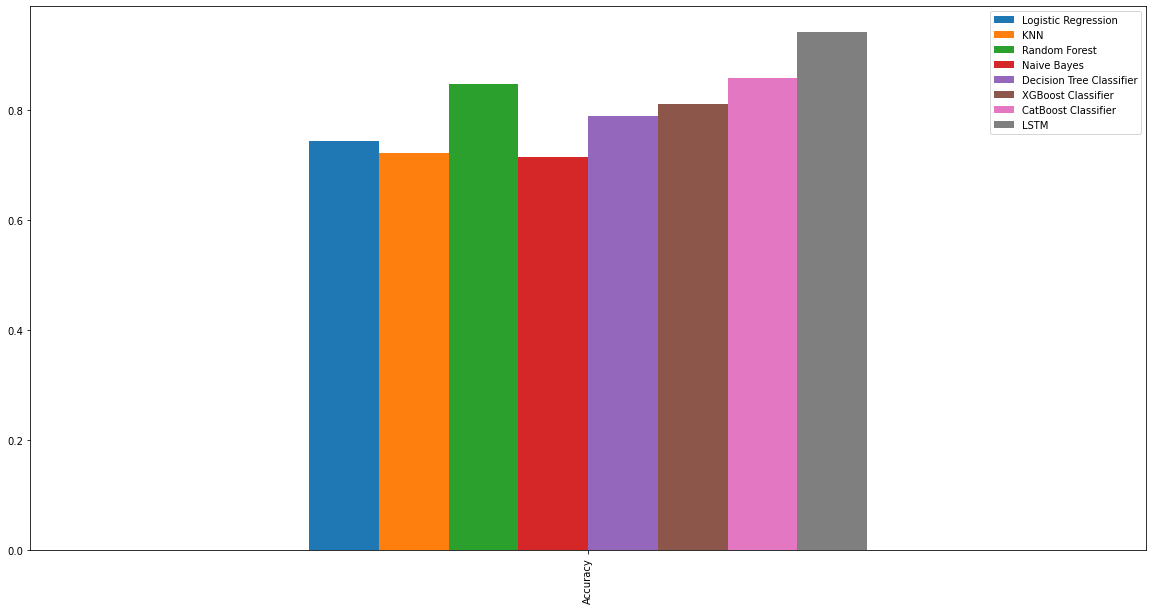

In [48]:
model_compare.plot(kind="bar", figsize=(20, 10));

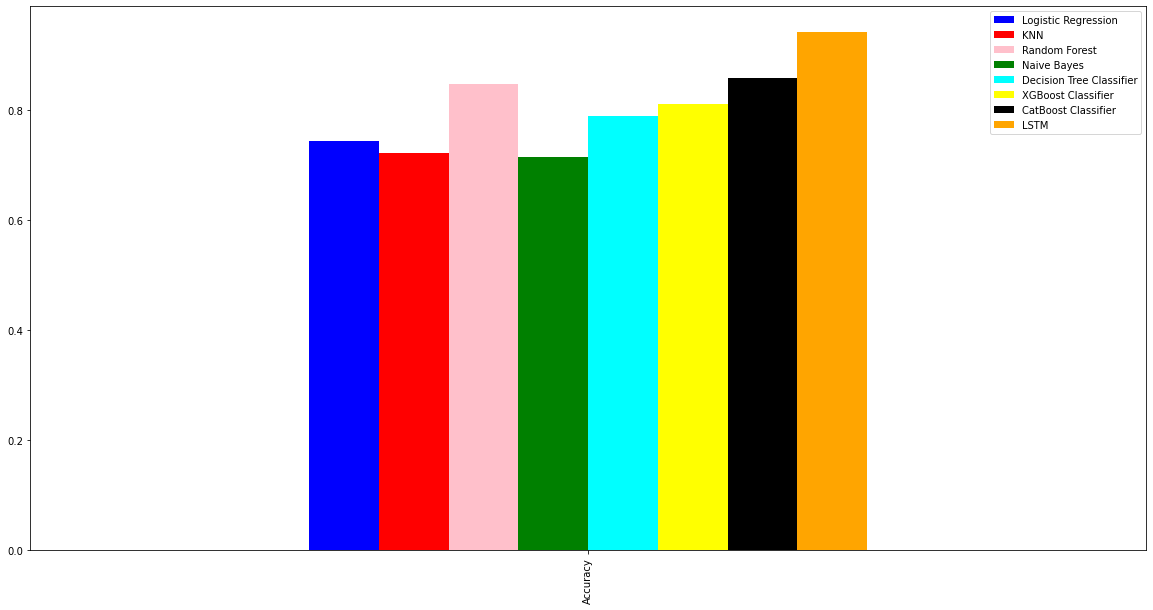

In [49]:
model_compare.plot(kind="bar", color=['blue', 'red','pink','green', 'cyan', 'yellow', 'black','orange'], figsize=(20, 10));

# Evaluation of Models

**Tabulating the results of various implemented models.**

In [50]:
# score_1 = accuracy_score(y_test,pred_1)
# score_2 = accuracy_score(y_test,pred_2)
# score_3 = accuracy_score(y_test,pred_3)
# score_4 = accuracy_score(y_test,pred_4)
# score_5 = accuracy_score(y_test,pred_5)
# score_6 = accuracy_score(y_test,pred_6)
# score_7 = accuracy_score(y_test,predictions)
# results = pd.DataFrame([["Logistic Regression",score_1],["Naive Bayes",score_2],["Decision Tree",score_3],
#                        ["Random Forest",score_4],["XGBOOST",score_5],["CatBoost",score_6],["LSTM",score_7]],columns=["Model","Accuracy"])
# results

**Discussion: From the above results, it appears that LSTM Model gives the highest accuracy amongst various models. Therefore, it is selected as the final model for making predictions on final testing data.**

## RandomizedSearch CV

### Only trying this on RF, CatBoost, XGBoost and Decision Trees

In [51]:
# Create a hyperparameter grid for RandomForestClassifier
rfc_grid = {"n_estimators": np.arange(0, 1000, 50),
           "max_depth": [None, 1, 2, 3, 5],
           "min_samples_split": np.arange(0, 10, 2),
           "min_samples_leaf": np.arange(0, 10, 1)}

# Create a hyperparameter grid for DecisionTreesClassifier
dtc_grid = {"max_depth": [0, 1, 2, 3],
           "min_samples_split": np.arange(0, 10, 1),
           "min_samples_leaf": [0, 1, 2, 3],
           "max_leaf_nodes": [0, 1, 2, 3]}

# Create a hyperparameter grid for XGBoostClassifier
xgb_grid = {"max_depth" : np.arange(0, 10, 1),
            "learning_rate" : [0, 0.01, 0.05, 0.1, 0.15, 0.2],
            "n_estimators" : np.arange(0, 1000, 50),
            "verbosity" : [0, 1]}

# Create a hyperparameter grid for CatBoostClassifier
catb_grid = {'depth'         : [4,5,6,7,8,9,10],
             'learning_rate' : [0.01,0.02,0.03,0.04],
             'iterations'    : [10, 20,30,40,50,60,70,80,90, 100]}

In [52]:
# Tune RFC
np.random.seed(12)

# Setup random hyperparameeter search for RFC
rs_rfc = RandomizedSearchCV(RandomForestClassifier(),
                                param_distributions=rfc_grid,
                                cv=5,
                                n_iter=20,
                                verbose=True)

# Fit random hyperparameter search model for RFC
rs_rfc.fit(X_train, Y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


C:\Users\khand\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\khand\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\khand\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 393, in fit
    for i, t in enumerate(trees))
  File "C:\Users\khand\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\khand\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\khand\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  File "C:\Users\khand\anaco

C:\Users\khand\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\khand\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\khand\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 393, in fit
    for i, t in enumerate(trees))
  File "C:\Users\khand\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\khand\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\khand\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  File "C:\Users\khand\anaco

C:\Users\khand\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\khand\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\khand\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 393, in fit
    for i, t in enumerate(trees))
  File "C:\Users\khand\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\khand\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\khand\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  File "C:\Users\khand\anaco

C:\Users\khand\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\khand\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\khand\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 393, in fit
    for i, t in enumerate(trees))
  File "C:\Users\khand\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\khand\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\khand\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  File "C:\Users\khand\anaco

C:\Users\khand\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\khand\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\khand\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 393, in fit
    for i, t in enumerate(trees))
  File "C:\Users\khand\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\khand\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\khand\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  File "C:\Users\khand\anaco

C:\Users\khand\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\khand\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\khand\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 393, in fit
    for i, t in enumerate(trees))
  File "C:\Users\khand\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\khand\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\khand\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  File "C:\Users\khand\anaco

C:\Users\khand\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\khand\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\khand\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 393, in fit
    for i, t in enumerate(trees))
  File "C:\Users\khand\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\khand\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\khand\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  File "C:\Users\khand\anaco

C:\Users\khand\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\khand\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\khand\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 393, in fit
    for i, t in enumerate(trees))
  File "C:\Users\khand\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\khand\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\khand\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  File "C:\Users\khand\anaco

C:\Users\khand\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\khand\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\khand\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 393, in fit
    for i, t in enumerate(trees))
  File "C:\Users\khand\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\khand\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\khand\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  File "C:\Users\khand\anaco

C:\Users\khand\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\khand\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\khand\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 393, in fit
    for i, t in enumerate(trees))
  File "C:\Users\khand\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\khand\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\khand\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  File "C:\Users\khand\anaco

RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(), n_iter=20,
                   param_distributions={'max_depth': [None, 1, 2, 3, 5],
                                        'min_samples_leaf': array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
                                        'min_samples_split': array([0, 2, 4, 6, 8]),
                                        'n_estimators': array([  0,  50, 100, 150, 200, 250, 300, 350, 400, 450, 500, 550, 600,
       650, 700, 750, 800, 850, 900, 950])},
                   verbose=True)

In [53]:
# Find the best hyperparameters
rs_rfc.best_params_

{'n_estimators': 900,
 'min_samples_split': 6,
 'min_samples_leaf': 2,
 'max_depth': None}

In [54]:
# Best score
rs_rfc.score(x_test, y_test)

0.846

In [ ]:
# Setup random seed
np.random.seed(12)

# Setup random hyperparameter search for DecisionTreeClassifier
rs_dtc = RandomizedSearchCV(DecisionTreeClassifier(),
                           param_distributions=dtc_grid,
                           cv=5,
                           n_iter=20,
                           verbose=True)

# Fit the random hyperparameter search model for DecisionTreeClassifier()
rs_dtc.fit(X_train, Y_train)

In [ ]:
# Find the best hyperparameters
rs_dtc.best_params_

In [ ]:
# Best score
rs_dtc.score(x_test, y_test)

In [ ]:
# Setup random seed
np.random.seed(12)

# Setup random hyperparameter search for XGB Classifier
rs_xgb = RandomizedSearchCV(XGBClassifier(),
                           param_distributions=catb_grid,
                           cv=5,
                           n_iter=30,
                           verbose=True)

# Fit the random hyperparameter search model for XGBClassifier()
rs_xgb.fit(X_train, Y_train)

In [ ]:
# Find the best hyperparameters
rs_xgb.best_params_

In [ ]:
# Best score
rs_xgb.score(x_test, y_test)

In [ ]:
# Setup random seed
np.random.seed(12)

# Setup random hyperparameter search for XGB Classifier
rs_cbc = RandomizedSearchCV(CatBoostClassifier(),
                           param_distributions=catb_grid,
                           cv=5,
                           n_iter=40,
                           verbose=True)

# Fit the random hyperparameter search model for XGBClassifier()
rs_cbc.fit(X_train, Y_train)

In [ ]:
# Find the best hyperparameters
rs_cbc.best_params_

In [ ]:
# Best score
rs_cbc.score(x_test, y_test)

In [ ]:
# Make predictions with tuned model
y_preds = rs_rfc.predict(x_test)

In [ ]:
y_preds

In [ ]:
len(y_preds)

In [ ]:
len(x_test)

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(font_scale=1.5)

def plot_conf_mat(y_test, y_preds):
    
    fig, ax = plt.subplots(figsize=(8, 8))
    ax = sns.heatmap(confusion_matrix(y_test, y_preds),
                     annot=True,
                     cbar=False)
    plt.xlabel("True Label")
    plt.ylabel("Predicted Label using RFC")
    
plot_conf_mat(y_test, y_preds)

In [ ]:
# Plot ROC curve and calculate AUC metric
plot_roc_curve(rs_rfc, x_test, y_test)